In [1]:
import os
import pickle
import datetime
import itertools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

from main import *
%matplotlib inline

### Experiment Goals
1. pricing strategy: constant price / linear price
2. the effect of hurricane, we assume all hurricane will make a 5 days orange price strike
3. refill strategy: refill our inventory when the inventory volume is only 30%, 15%, or 8%

### basic settings
1. orange price is the `Orange Juice Futures Historical Data.csv`, and we divide the original price by 2
2. we always refill 50 unit of orange
3. our inventory always start with 50 units of orange

### Questions
1. how many customers come without buying anything (arrived but demand=0)
2. how many days the inventory level equals to 0
3. how many times we refill the inventory
4. how many times we cannot fulfill customers' demand (the inventory level is smaller than the demand)
5. what is the average orange freshness we sell to our customers
6. how many units of orange are decayed
7. what is the average profit?
8. what is the average cost?
9. what is the average revenue (profit - cost)
11. what combination of price strategy and refill level we would recommend
12. what is the effect of hurricane on the revenue of recommended strategy?

#### Print out all default environment parameters

In [2]:
get_all_default_parameters()

{'MAX_FRESHNESS': 100,
 'MAX_PRICE': 130,
 'MAX_INVENTORY': 200,
 'CONSTANT_PRICE': 125,
 'LINEAR_PRICE_BETA': -0.05,
 'REFILL_UNIT': 50,
 'STARTING_UNIT': 50,
 'demand_attr': (-0.2, 100, 200),
 'arrival_attr': (30, 2, 60),
 'total_day': 365}

In [3]:
bins = 20
figsize = (10, 6)

#### Load Orange Price (without Hurricane Effect)

In [4]:
df = load_orange_price()
orange_price = get_orange_price(df, seed=0)
orange_price.head()

0    61.20
1    61.20
2    60.82
3    60.65
4    60.65
Name: Final Price, dtype: float64

Text(0.5, 0, 'date')

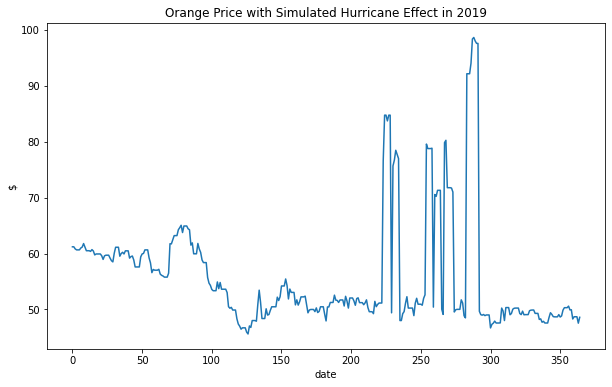

In [5]:
orange_price.plot(figsize=(10, 6))
plt.title('Orange Price with Simulated Hurricane Effect in 2019')
plt.ylabel('$')
plt.xlabel('date')

#### Experiments

In [6]:
N = 100
strategyList = ['constant', 'linear']
refill_percentage = [0.30, 0.15, 0.08]

best_revenue = float("-inf")
best_strategy = (None, None)
best_result = None

In [7]:
list(itertools.product(strategyList, refill_percentage))

[('constant', 0.3),
 ('constant', 0.15),
 ('constant', 0.08),
 ('linear', 0.3),
 ('linear', 0.15),
 ('linear', 0.08)]

In [8]:
logPath = os.getcwd() + '/log.txt'

In [9]:
set_seed = False

In [10]:
logFile = open(logPath, 'w')

for s, r in tqdm(itertools.product(strategyList, refill_percentage), "All", ncols=300, position=0):
    
    resultList = []
    for seed in tqdm(range(N), "Sub", ncols=300, position=1, leave=False):
        logMessage = '%s, %.2f, %s\n'
        logFile.write(logMessage % (s, r, str(seed)))
        if not set_seed:
            seed = None
        
        df = load_orange_price()
        orange_price = get_orange_price(df, seed=seed)
        resultList.append( system(orange_price, strategy=s, refill_percentage=r, seed=seed) )
    
    result = getAverageResult(*resultList)
    logMessage = '='*20 + '\n'
    logFile.write(logMessage)
    print('when strategy=%s \t refill_percentage=%.2f, \tthe average revenue is %.2f\n' % (s, r, result['avgRevenue']))

    if result['avgRevenue'] > best_revenue:
        best_revenue = result['avgRevenue']
        best_strategy = (s, r)
        best_result = result
        
        
logFile.close()

when strategy=constant 	 refill_percentage=0.30, 	the average revenue is 6396.85



when strategy=constant 	 refill_percentage=0.15, 	the average revenue is 63286.37



when strategy=constant 	 refill_percentage=0.08, 	the average revenue is 80003.11



when strategy=linear 	 refill_percentage=0.30, 	the average revenue is 5817.10



when strategy=linear 	 refill_percentage=0.15, 	the average revenue is 66207.66



when strategy=linear 	 refill_percentage=0.08, 	the average revenue is 81210.27




In [11]:
resultFileName = os.getcwd() + '/strategy=%s&refill_perct=%.f&'
resultFileName += datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
resultFileName += '.pkl'

print('the result is stored in pickle file: %s' % resultFileName)
with open(resultFileName % (best_strategy[0], best_strategy[1] * 100), 'wb') as handle:
    pickle.dump(best_result, handle, protocol=pickle.HIGHEST_PROTOCOL)

the result is stored in pickle file: /home/jovyan/work/E4404-Simulation-Project/strategy=%s&refill_perct=%.f2020-12-21 18:26:17.pkl


In [12]:
# # load previous results
# file_name = 'strategy=linear&refill_perct=82020-12-21 18:26:17.pkl'
# with open(file_name, 'rb') as handle:
#     best_result = pickle.load(handle)

In [13]:
best_strategy, best_revenue

(('linear', 0.08), 81210.26897800865)

Profit 0.95 confidence interval: (194445.845, 201767.728)
Cost 0.95 confidence interval: (115419.416, 118373.619)


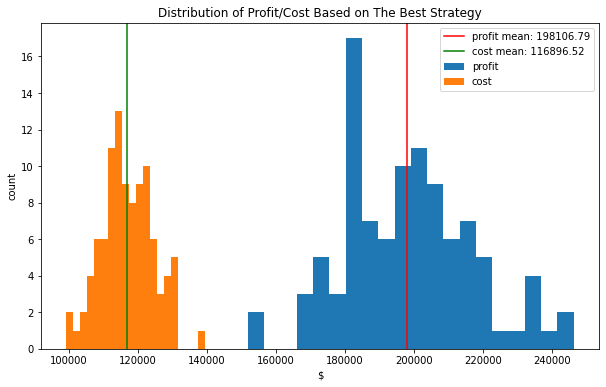

In [14]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['Profit'], bins=bins, label='profit')
plt.hist(best_result['Cost'], bins=bins, label='cost')
ax.axvline(best_result['avgProfit'], color='red', label='profit mean: %.2f' % best_result['avgProfit'])
ax.axvline(best_result['avgCost'], color='green', label='cost mean: %.2f' % best_result['avgCost'])
plt.title('Distribution of Profit/Cost Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('$')
plt.legend()

calculateConfidenceInterval(best_result['Profit'], names='Profit')
calculateConfidenceInterval(best_result['Cost'], names='Cost')

Revenue 0.95 confidence interval: (78863.284, 83557.254)


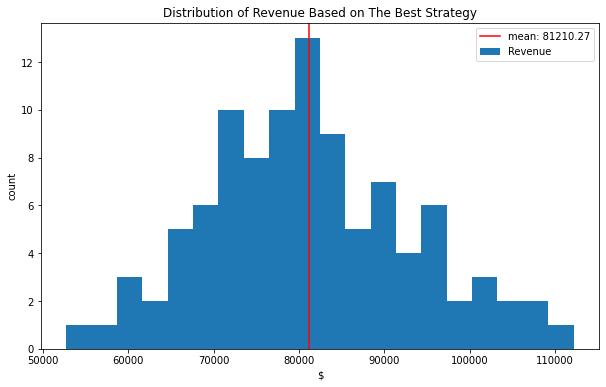

In [15]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['Revenue'], bins=bins, label='Revenue')
ax.axvline(best_result['avgRevenue'], color='red', label='mean: %.2f' % best_result['avgRevenue'])
plt.title('Distribution of Revenue Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('$')
plt.legend()

calculateConfidenceInterval(best_result['Revenue'], names='Revenue')

1. how many customers come without buying anything (arrived but demand=0)

Zero Demand Arrival 0.95 confidence interval: (0.261, 0.272)


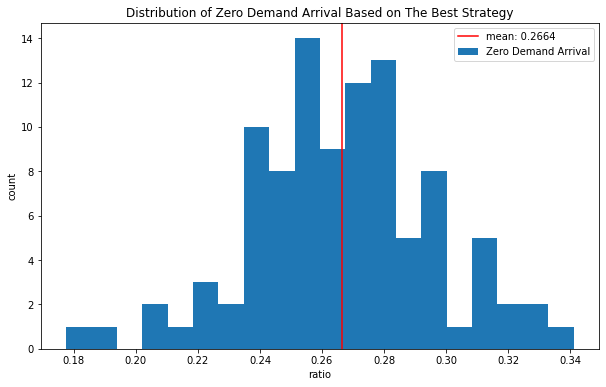

In [16]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['CustomerZeroDemand'], bins=bins, label='Zero Demand Arrival')
ax.axvline(best_result['avgCustomerZeroDemand'], color='red', label='mean: %.4f' % best_result['avgCustomerZeroDemand'])
plt.title('Distribution of Zero Demand Arrival Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('ratio')
plt.legend()

calculateConfidenceInterval(best_result['CustomerZeroDemand'], names='Zero Demand Arrival')

2. how many days the inventory level equals to 0

Zero Inventory Level 0.95 confidence interval: (0.059, 0.065)


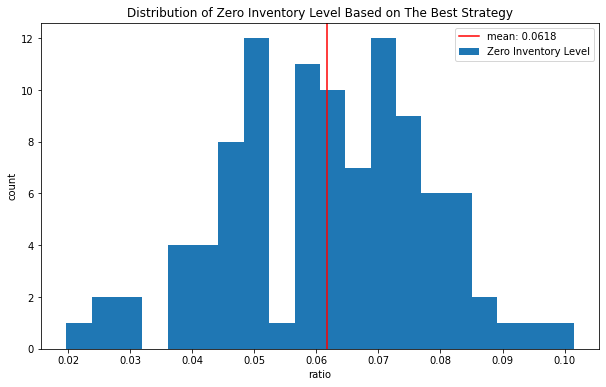

In [17]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['ZeroInventoryLevel'], bins=bins, label='Zero Inventory Level')
ax.axvline(best_result['avgZeroInventoryLevel'], color='red', label='mean: %.4f' % best_result['avgZeroInventoryLevel'])
plt.title('Distribution of Zero Inventory Level Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('ratio')
plt.legend()

calculateConfidenceInterval(best_result['ZeroInventoryLevel'], names='Zero Inventory Level')

3. how many times we refill the inventory

Refill Times 0.95 confidence interval: (40.622, 41.618)


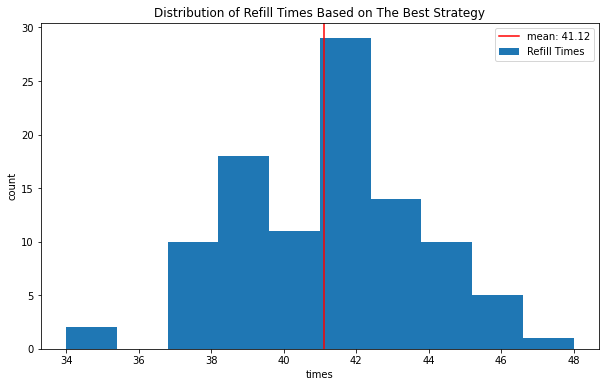

In [18]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['RefillTimes'], label='Refill Times')
ax.axvline(best_result['avgRefillTimes'], color='red', label='mean: %.2f' % best_result['avgRefillTimes'])
plt.title('Distribution of Refill Times Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('times')
plt.legend()

calculateConfidenceInterval(best_result['RefillTimes'], names='Refill Times')

4. how many times we cannot fulfill customers' demand (the inventory level is smaller than the demand)

Not Fulfill Ratio 0.95 confidence interval: (0.086, 0.093)


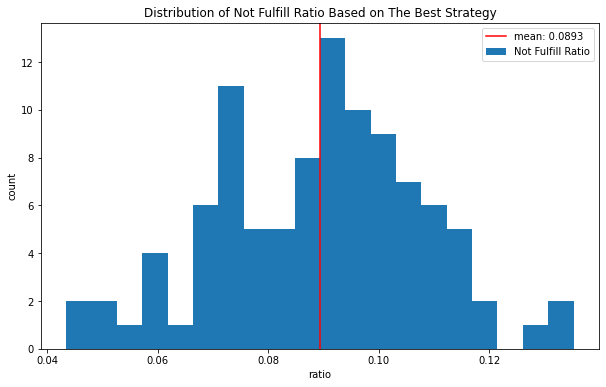

In [19]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['NotFulfillRatio'], bins=bins, label='Not Fulfill Ratio')
ax.axvline(best_result['avgNotFulfillRatio'], color='red', label='mean: %.4f' % best_result['avgNotFulfillRatio'])
plt.title('Distribution of Not Fulfill Ratio Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('ratio')
plt.legend()

calculateConfidenceInterval(best_result['NotFulfillRatio'], names='Not Fulfill Ratio')

5. what is the average orange freshness we sell to our customers

Freshness 0.95 confidence interval: (74.108, 74.967)


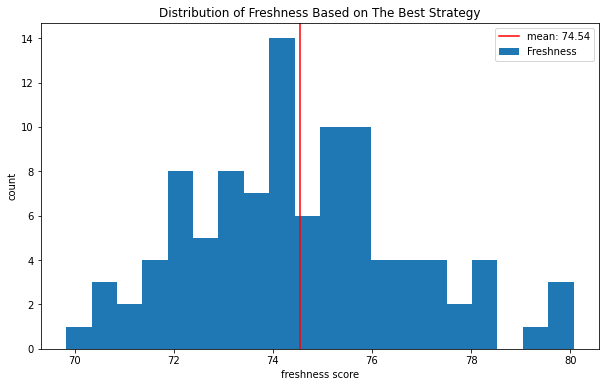

In [20]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['Freshness'], bins=bins, label='Freshness')
ax.axvline(best_result['avgFreshness'], color='red', label='mean: %.2f' % best_result['avgFreshness'])
plt.title('Distribution of Freshness Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('freshness score')
plt.legend()

calculateConfidenceInterval(best_result['Freshness'], names='Freshness')

6. how many units of orange are decayed

Decay Units 0.95 confidence interval: (462.613, 478.187)


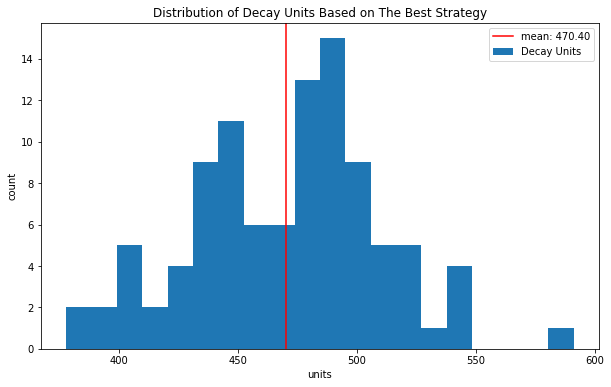

In [21]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(best_result['DecayUnits'], bins=bins, label='Decay Units')
ax.axvline(best_result['avgDecayUnits'], color='red', label='mean: %.2f' % best_result['avgDecayUnits'])
plt.title('Distribution of Decay Units Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('units')
plt.legend()

calculateConfidenceInterval(best_result['DecayUnits'], names='Decay Units')

7. what is the effect of hurricane on the revenue of recommended strategy?

In [25]:
withHurricane = []
withoutHurricane = []

s = best_strategy[0]
r = best_strategy[1]

for seed in tqdm(range(N)):
    if not set_seed:
        seed = None

    df = load_orange_price()
    orange_price = get_orange_price(df, return_origin=True, seed=seed)
    withHurricane.append( system(orange_price['Final Price'], strategy=s, refill_percentage=r, seed=seed) )
    withoutHurricane.append( system(orange_price['Price'], strategy=s, refill_percentage=r, seed=seed) )

In [26]:
wh = getAverageResult(*withHurricane)
woh = getAverageResult(*withoutHurricane)

Revenue with hurricane 0.95 confidence interval: (79625.56, 84084.364)
Revenue withOut hurricane 0.95 confidence interval: (82682.396, 87321.207)


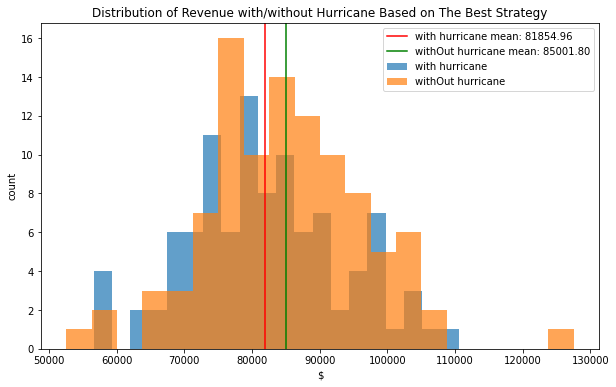

In [27]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
plt.hist(wh['Revenue'], bins=bins, label='with hurricane', alpha=0.7)
plt.hist(woh['Revenue'], bins=bins, label='withOut hurricane', alpha=0.7)
ax.axvline(wh['avgRevenue'], color='red', label='with hurricane mean: %.2f' % wh['avgRevenue'])
ax.axvline(woh['avgRevenue'], color='green', label='withOut hurricane mean: %.2f' % woh['avgRevenue'])
plt.title('Distribution of Revenue with/without Hurricane Based on The Best Strategy')
plt.ylabel('count')
plt.xlabel('$')
plt.legend()

calculateConfidenceInterval(wh['Revenue'], names='Revenue with hurricane')
calculateConfidenceInterval(woh['Revenue'], names='Revenue withOut hurricane')